In [1]:
%%time
# Imports:

# defaults
import math
import numpy as np
import matplotlib.pyplot as plt
import csv

# torch stuff
import torch
import torch.nn as nn
from torch.optim import Adam, NAdam
from torch.utils.data import TensorDataset, DataLoader

# UNet dependencies
from denoising_diffusion_pytorch import Unet1D # basic unet for unconditioned
# from functools import partial
# from einops import rearrange, reduce
# from einops.layers.torch import Rearrange

# Smact check dependencies
import smact
from smact.screening import pauling_test
import pandas
import itertools
from fractions import Fraction
import functools
from pymatgen.core.composition import Composition

# Typenotes
from typing import Tuple
from typing import List

# file import
from helper_formula_parse import *
from supercon_wtypes_parse import *
from helper_dataset_shuffle import *
from dataset_creation import *
from helper_reverse_formula import *
# from helper_unet_functions import *
from smact_validity_checks import *
from save_valid_compounds_to_csv import *
# from unet1d import * - own UNet for later Few-shot diffusion

CPU times: total: 2.97 s
Wall time: 8.07 s


In [2]:
SUPERCON_DATA_FILE = "SuperCon_with_types.dat"

# element table to set up vectors in R^(1x96): must len(element_table) = 96
element_table = ["H","He","Li","Be","B","C","N","O","F","Ne","Na","Mg","Al","Si","P","S","Cl","Ar","K","Ca","Sc","Ti","V","Cr","Mn","Fe","Co",
              "Ni","Cu","Zn","Ga","Ge","As","Se","Br","Kr","Rb","Sr","Y","Zr","Nb","Mo","Tc","Ru","Rh","Pd","Ag","Cd","In","Sn","Sb","Te",
              "I","Xe","Cs","Ba","La","Ce","Pr","Nd","Pm","Sm","Eu","Gd","Tb","Dy","Ho","Er","Tm","Yb","Lu","Hf","Ta","W","Re","Os","Ir",
              "Pt","Au","Hg","Tl","Pb","Bi","Po","At","Rn","Fr","Ra","Ac","Th","Pa","U","Np","Pu","Am","Cm"]

# validate table correctness
validation_element_table = ["H", "He", "Li", "Be", "B", "C", "N", "O", "F", "Ne", "Na", "Mg", "Al", "Si", "P", "S", "Cl", "Ar", "K", "Ca", 
                            "Sc", "Ti", "V", "Cr", "Mn", "Fe", "Co", "Ni", "Cu", "Zn", "Ga", "Ge", "As", "Se", "Br", "Kr", "Rb", "Sr","Y",
                            "Zr","Nb","Mo","Tc","Ru","Rh","Pd","Ag","Cd","In","Sn","Sb","Te","I","Xe","Cs","Ba","La","Ce","Pr","Nd","Pm",
                            "Sm","Eu","Gd","Tb","Dy","Ho","Er","Tm","Yb","Lu","Hf","Ta","W","Re","Os","Ir","Pt","Au","Hg","Tl","Pb" ,"Bi" ,
                            "Po" ,"At" ,"Rn" ,"Fr" ,"Ra" ,"Ac" ,"Th" ,"Pa" ,"U" ,"Np" ,"Pu" ,"Am" ,"Cm"]

assert(len(element_table) == 96)
print("NOTE: Correct element table length.")

assert(validation_element_table == element_table)
print("NOTE: Valid table.")

NOTE: Correct element table length.
NOTE: Valid table.


In [3]:
returned_datasets = prepare_datasets_for_classes(SUPERCON_DATA_FILE, element_table, 1/20, True)

torch.Size([16708, 96])
torch.Size([7589, 96])
torch.Size([1440, 96])
torch.Size([7679, 96])
Train Data Size: 15873 | Test Data Size: 835
Train Data Size: 7210 | Test Data Size: 379
Train Data Size: 1368 | Test Data Size: 72
Train Data Size: 7296 | Test Data Size: 383


In [4]:
# Unpack the list into individual variables (if needed)
torch_diffusion_data_raw_unconditional_train = returned_datasets[0]
torch_diffusion_data_raw_cuprates_train = returned_datasets[1]
torch_diffusion_data_raw_pnictides_train = returned_datasets[2]
torch_diffusion_data_raw_others_train = returned_datasets[3]

torch_diffusion_data_raw_unconditional_test = returned_datasets[4]
torch_diffusion_data_raw_cuprates_test = returned_datasets[5]
torch_diffusion_data_raw_pnictides_test = returned_datasets[6]
torch_diffusion_data_raw_others_test = returned_datasets[7]

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"NOTE: Using Device: \"{device}\"","|",(f"{torch.cuda.get_device_name(0)}" if torch.cuda.is_available() else "CPU"))

NOTE: Using Device: "cuda:0" | NVIDIA GeForce RTX 3060 Ti


In [6]:
def get_named_beta_schedule(schedule_name: str, num_diffusion_timesteps: int) -> torch.Tensor:
    """
    Get a pre-defined beta schedule for the given name. 
    Function adapted from https://github.com/openai/improved-diffusion/blob/main/improved_diffusion/gaussian_diffusion.py
    Improved support for PyTorch.

    :param schedule_name: The name of the beta schedule.
    :param num_diffusion_timesteps: The number of diffusion timesteps.
    :return: The beta schedule tensor.
    :rtype: torch.Tensor[torch.float64]
    """
    if schedule_name == "linear":
        # Linear schedule from Ho et al, extended to work for any number of diffusion steps.
        scale = 1000 / num_diffusion_timesteps
        beta_start = scale * 0.0001
        beta_end = scale * 0.02
        return torch.linspace(
            beta_start, beta_end, num_diffusion_timesteps
        ).to(torch.float64)
    elif schedule_name == "cosine":
        return betas_for_alpha_bar(
            num_diffusion_timesteps,
            lambda t: math.cos((t + 0.008) / 1.008 * math.pi / 2) ** 2,
        )
    else:
        raise NotImplementedError(f"unknown beta schedule: {schedule_name}")


In [7]:
def betas_for_alpha_bar(num_diffusion_timesteps: int, alpha_bar: float, max_beta=0.999) -> torch.Tensor:
    """
    Create a beta schedule that discretizes the given alpha_t_bar function,
    which defines the cumprod of (1-beta) over time from t = [0,1].
    Function adapted from https://github.com/openai/improved-diffusion/blob/main/improved_diffusion/gaussian_diffusion.py
    Improved support for PyTorch.

    :param num_diffusion_timesteps: The number of betas to produce.
    :param alpha_bar: A lambda that takes an argument t from 0 to 1 and produces
                      the cumulative product of (1-beta) up to that part of the
                      diffusion process.
    :param max_beta: The maximum beta to use; use values lower than 1 to prevent
                     singularities (Improved Diffusion Paper).
    :return: The beta schedule tensor.
    :rtype: torch.Tensor[torch.float64]
    """
    betas = []
    for i in range(num_diffusion_timesteps):
        t1 = i / num_diffusion_timesteps
        t2 = (i + 1) / num_diffusion_timesteps
        betas.append(min(1 - alpha_bar(t2) / alpha_bar(t1), max_beta))
    return torch.Tensor(betas).to(torch.float64)


In [8]:
class GaussianDiffusion1D:
    """
    Class for Gaussian diffusion of 1D Tensors (vector diffusion).
    """

    def __init__(
        self,
        sequence_length: int,
        timesteps: int,
        beta_schedule_type: str
    ):
        """
        Initializes the GaussianDiffusion1D class.

        :param sequence_length: Length of the sequence.
        :param timesteps: Number of timesteps.
        :param beta_schedule_type: Type of beta schedule. Can be "linear" or "cosine".

        :raises TypeError: If the beta schedule type is unknown.
        """
        self.sequence_length = sequence_length
        self.timesteps = timesteps
        self.beta_schedule_type = beta_schedule_type

        if self.beta_schedule_type == "linear":
            self.betas = get_named_beta_schedule(self.beta_schedule_type, self.timesteps)
        elif self.beta_schedule_type == "cosine":
            self.betas = get_named_beta_schedule(self.beta_schedule_type, self.timesteps)
        else:
            raise TypeError(f"{self.beta_schedule_type} is an unknown beta schedule type.")

        self.alphas = 1 - self.betas
        self.alphas_bar = torch.cumprod(self.alphas, axis=0)

    def forward(
        self,
        x_0: torch.Tensor,
        t: torch.Tensor,
        device: str
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Forward diffusion process. Adding noise ~ N(0, I) to vectors.

        :param x_0: Original vector of shape (B, C, L).
        :param t: Timestep tensor of shape (B,).
        :param device: Device to be used.

        :return: Tuple containing mean tensor and noise tensor.
        """
        epsilon = torch.randn_like(x_0)
        alphas_bar_t = self.extract(self.alphas_bar, t, x_0.shape)

        mean = torch.sqrt(alphas_bar_t).to(device) * x_0.to(device)
        variance = torch.sqrt((1 - alphas_bar_t)).to(device) * epsilon.to(device)

        return mean + variance, epsilon.to(device)

    @torch.no_grad()
    def backward(
        self,
        x_t: torch.Tensor,
        t: torch.Tensor,
        model: nn.Module,
        **kwargs
    ) -> torch.Tensor:
        """
        Calls the model to predict the noise in the image and returns
        the denoised image (x_{t-1}).

        This method corresponds to the "big for loop" in the sampling algorithm (see algorithm 2 from Ho et al.).

        :param x_t: Current image tensor of shape (B, C, L).
        :param t: Timestep tensor of shape (B,).
        :param model: Model used to predict the noise in the image.
        :param **kwargs: Additional arguments to be passed to the model.

        :return: Denoised image tensor of shape (B, C, L).
        """
        betas_t = self.extract(self.betas, t, x_t.shape)
        sqrt_one_minus_alphas_bar_t = self.extract(torch.sqrt(1. - self.alphas_bar), t, x_t.shape)
        sqrt_recip_alphas_t = self.extract(torch.sqrt(1.0 / self.alphas), t, x_t.shape)
        mean = sqrt_recip_alphas_t * (x_t - ((betas_t / sqrt_one_minus_alphas_bar_t) * model(x_t, t, **kwargs)))
        posterior_variance_t = betas_t

        # Applies noise to this image if we are not in the last step yet.
        if t == 0:
            return mean
        else:
            z = torch.randn_like(x_t)
            variance = torch.sqrt(posterior_variance_t) * z
            return mean + variance

    @staticmethod
    def extract(
        values: torch.Tensor,
        t: torch.Tensor,
        x_0_shape: Tuple[int]
    ) -> torch.Tensor:
        """
        Picks the values from `values` according to the indices stored in `t`.

        :param values: Tensor of values to pick from.
        :param t: Index tensor.
        :param x_0_shape: Shape of the original tensor x_0.

        :return: Reshaped tensor with picked values.
        """
        batch_size = t.shape[0]
        vector_to_reshape = values.gather(-1, t.cpu())
        """
        if len(x_shape) - 1 = 2:
        reshape `out` to dims
        (batch_size, 1, 1)
        """
        return vector_to_reshape.reshape(batch_size, *((1,) * (len(x_0_shape) - 1))).to(t.device)


In [9]:
def plot_noise_distribution(noise: torch.Tensor, predicted_noise: torch.Tensor):
    """
    Plot noise distributions to visualize and compare predicted and ground truth noise.
    """
    plt.hist(noise.cpu().numpy().flatten(), density = True, alpha = 0.8, label = "ground truth noise")
    plt.hist(predicted_noise.cpu().numpy().flatten(), density = True, alpha = 0.8, label = "predicted noise")
    plt.legend()
    plt.show()

In [10]:
DIFFUSION_TIMESTEPS = 1000
diffusion_model = GaussianDiffusion1D(96, DIFFUSION_TIMESTEPS, "cosine")

In [16]:
# Hyperparameters
BATCH_SIZE = 64
NUM_WORKERS = 24 # TODO: test different values - change much bigger actually uses CPU (change to like 12)
NO_EPOCHS = 100
PRINT_FREQUENCY = 10
LR = 1e-4
VERBOSE = True
USE_VALIDATION_SET = True

In [17]:
diffusion_dataset_train = TensorDataset(torch_diffusion_data_raw_pnictides_train)
train_dataloader = DataLoader(diffusion_dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, drop_last=True)

if USE_VALIDATION_SET == True:
    diffusion_dataset_test = TensorDataset(torch_diffusion_data_raw_pnictides_test)
    test_dataloader = DataLoader(diffusion_dataset_test, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, drop_last=True)

In [18]:
unet = Unet1D(
    dim = 48,
    dim_mults = (1, 2, 3, 6),
    channels = 1
)
unet.to(device)

optimizer = torch.optim.NAdam(unet.parameters(), lr=LR)

---
Epoch: 0 | Train Loss 0.4596225129706519 | Val Loss 0.20700621604919434


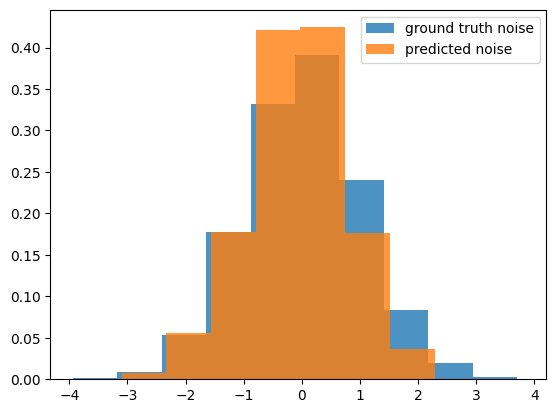

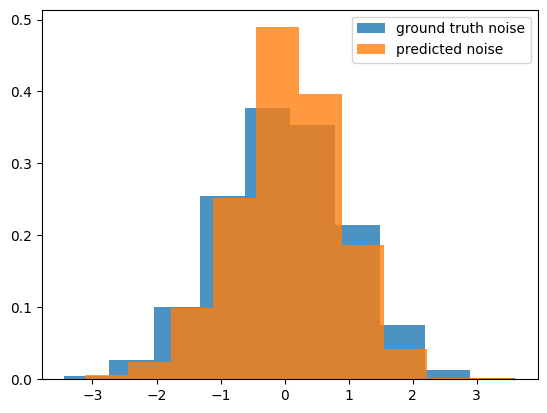

---
Epoch: 9 | Train Loss 0.0670855435587111 | Val Loss 0.06446397304534912


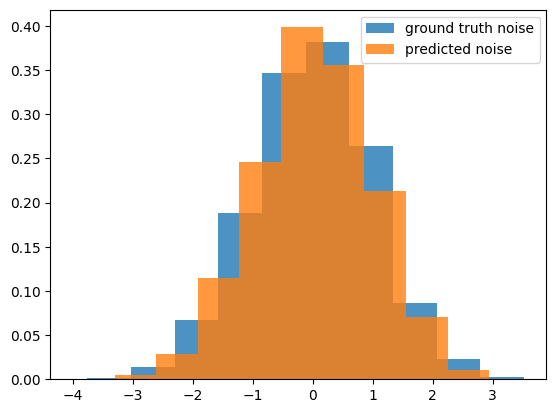

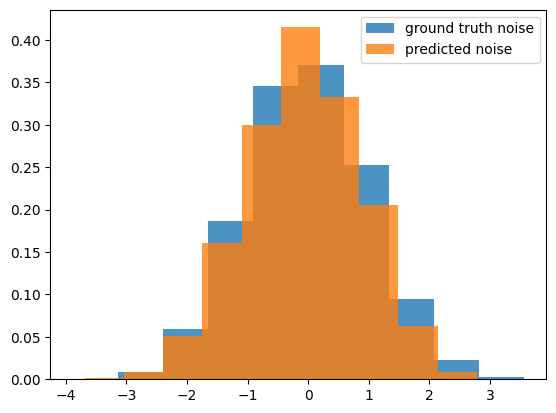

---
Epoch: 19 | Train Loss 0.045793221110389346 | Val Loss 0.040856510400772095


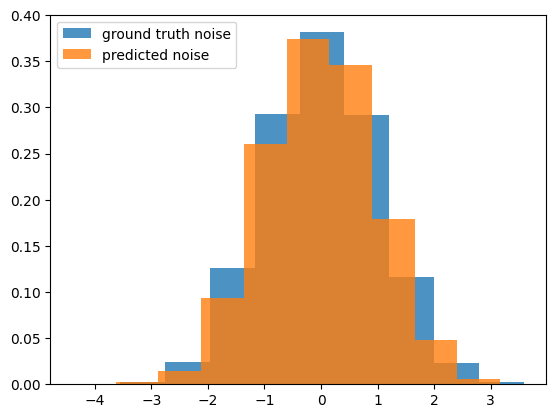

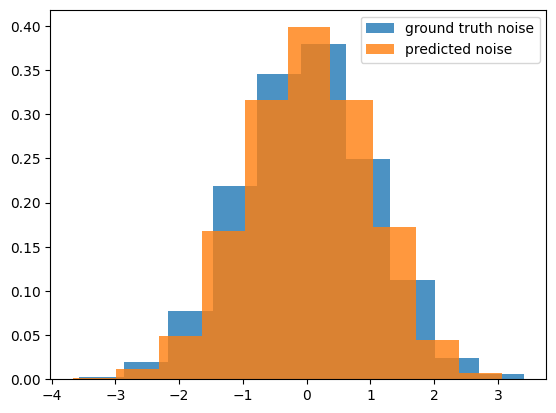

---
Epoch: 29 | Train Loss 0.0379095466896182 | Val Loss 0.05013692378997803


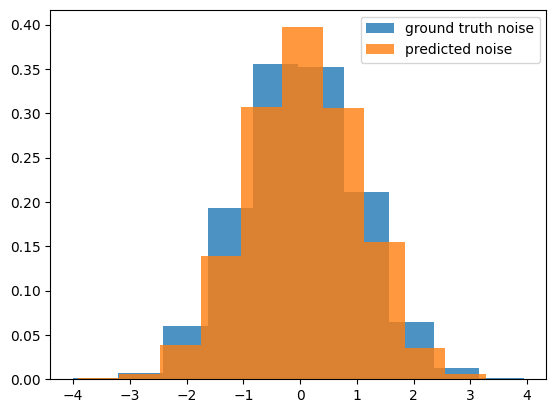

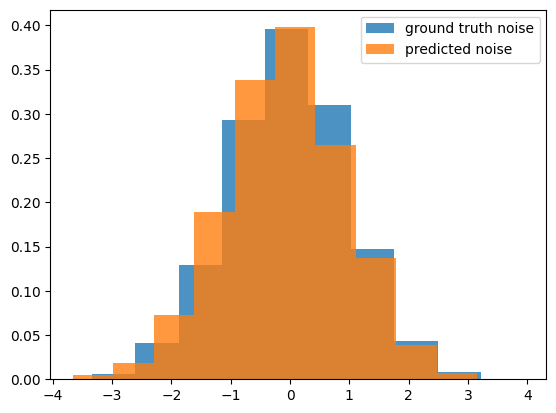

---
Epoch: 39 | Train Loss 0.029982019925401324 | Val Loss 0.045487962663173676


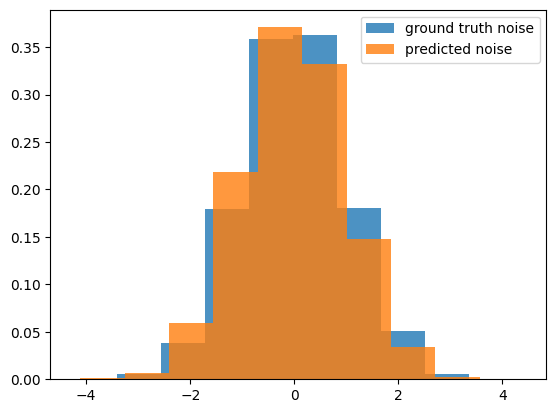

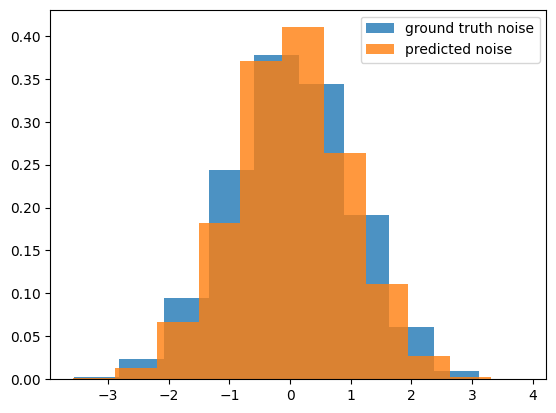

---
Epoch: 49 | Train Loss 0.03178637022418635 | Val Loss 0.03875068947672844


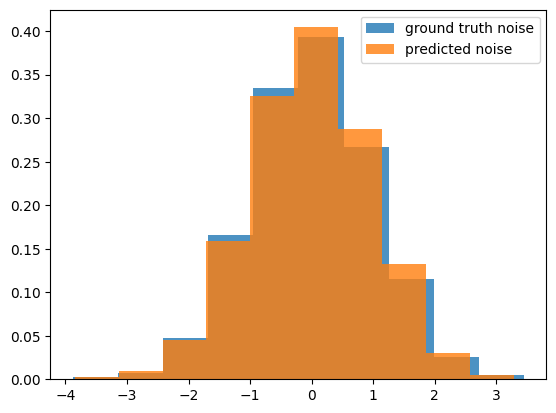

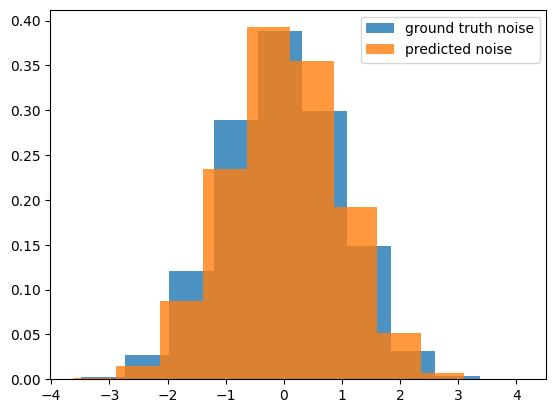

---
Epoch: 59 | Train Loss 0.03182953897686232 | Val Loss 0.02609848603606224


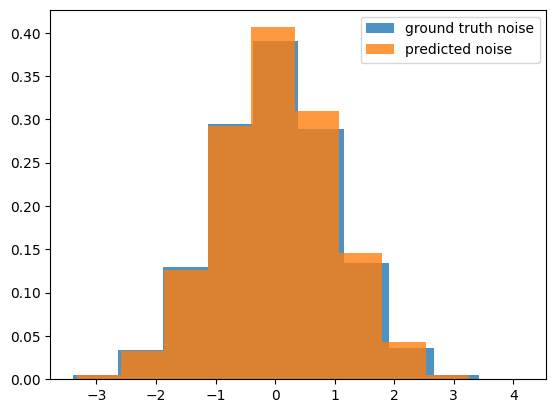

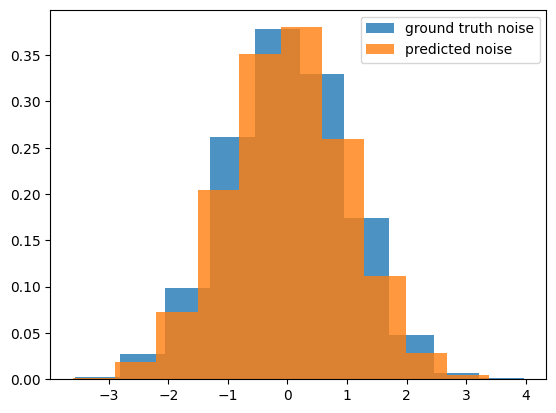

---
Epoch: 69 | Train Loss 0.028020492887922695 | Val Loss 0.03408674895763397


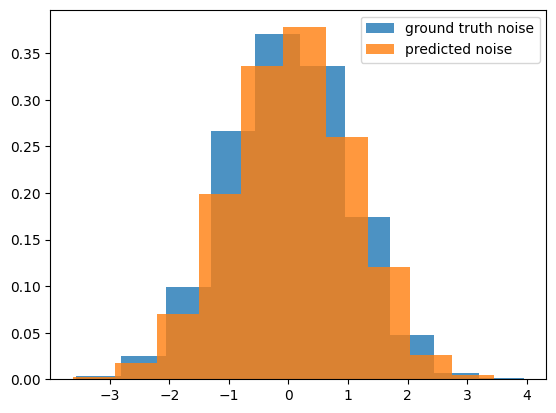

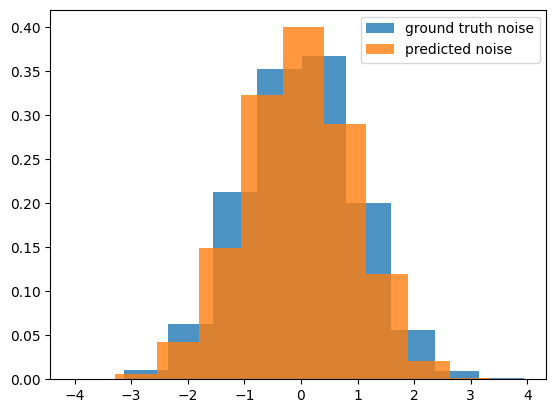

---
Epoch: 79 | Train Loss 0.025799381857117016 | Val Loss 0.017982862889766693


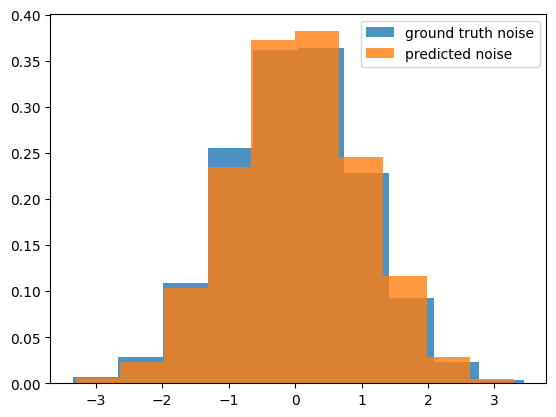

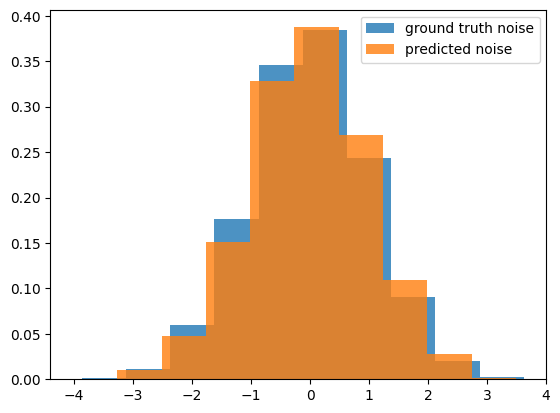

---
Epoch: 89 | Train Loss 0.025602322603975023 | Val Loss 0.027171630412340164


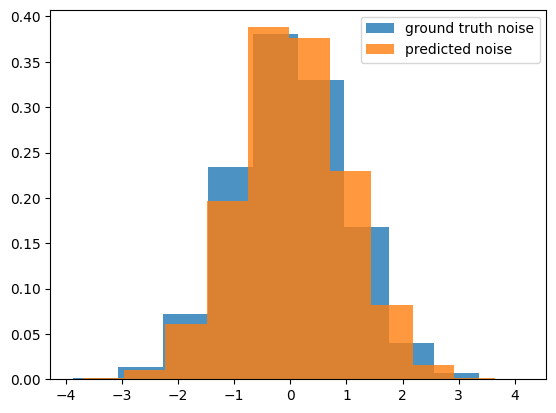

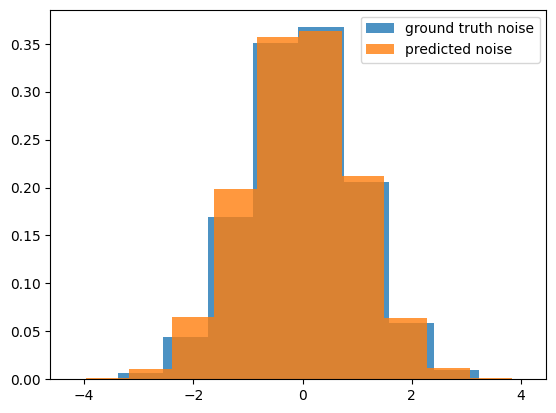

---
Epoch: 99 | Train Loss 0.025558395488631157 | Val Loss 0.035864658653736115


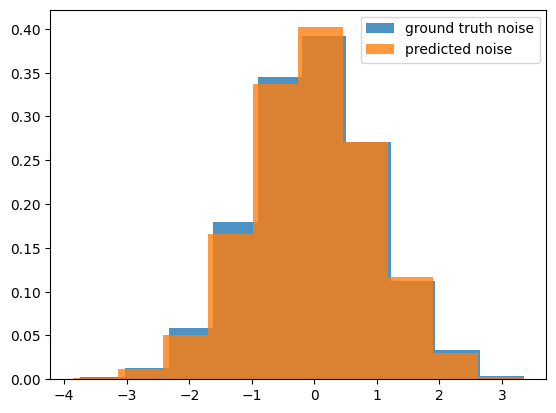

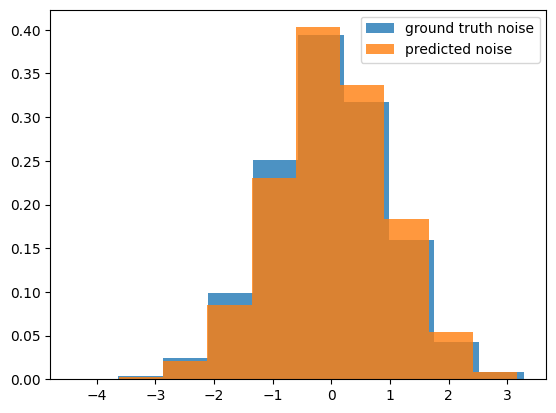

CPU times: total: 2min 35s
Wall time: 25min 29s


In [19]:
%%time
# Training Loop
training_steps_tracker = []
loss_tracker_train = [] # to plot train loss/training step - make sure outside for loop
loss_tracker_val = [] # to plot val loss/training step - make sure outside for loop
epoch_tracker = []
loss_tracker_train_epoch = [] # to plot train loss/epoch - make sure outside for loop
loss_tracker_val_epoch = [] # to plot val loss/epoch - make sure outside for loop
for epoch in range(NO_EPOCHS):
    mean_epoch_loss_train = [] # put in for loop - wipe clean each time
    mean_epoch_loss_val = [] # put in for loop - wipe clean each time
    
    # on train dataset
    for batch in train_dataloader:
        t = torch.randint(0, diffusion_model.timesteps, (BATCH_SIZE,)).long().to(device)
        batch_train = batch[0].unsqueeze(1).to(device)
        
        noisy_batch_train, gt_noise_train = diffusion_model.forward(batch_train, t, device) 
        predicted_noise_train = unet(noisy_batch_train.to(torch.float32), t)
        
        optimizer.zero_grad()
        # loss(pred, target)
        loss = torch.nn.functional.mse_loss(predicted_noise_train, gt_noise_train)
        loss_tracker_train.append(loss.item())
        training_steps_tracker.append(1)
        mean_epoch_loss_train.append(loss.item())
        loss.backward()
        optimizer.step()
    
    if USE_VALIDATION_SET == True:
        # on test dataset
        for batch in test_dataloader:
            t = torch.randint(0, diffusion_model.timesteps, (BATCH_SIZE,)).long().to(device)
            batch_val = batch[0].unsqueeze(1).to(device)

            noisy_batch_val, gt_noise_val = diffusion_model.forward(batch_val, t, device) 
            predicted_noise_val = unet(noisy_batch_val.to(torch.float32), t)

            loss = torch.nn.functional.mse_loss(predicted_noise_val, gt_noise_val)
            loss_tracker_train.append(loss.item())
            mean_epoch_loss_val.append(loss.item())
    
    epoch_tracker.append(epoch)
    loss_tracker_train_epoch.append(np.mean(mean_epoch_loss_train))
    if USE_VALIDATION_SET == True:
        loss_tracker_val_epoch.append(np.mean(mean_epoch_loss_val))
    
    # print loss(s)
    if epoch == 0 or epoch % PRINT_FREQUENCY == 9:
        print('---')
        if USE_VALIDATION_SET == True:
            print(f"Epoch: {epoch} | Train Loss {np.mean(mean_epoch_loss_train)} | Val Loss {np.mean(mean_epoch_loss_val)}")
        else:
            print(f"Epoch: {epoch} | Train Loss {np.mean(mean_epoch_loss_train)}")
        if VERBOSE:
            with torch.no_grad():
                plot_noise_distribution(gt_noise_train, predicted_noise_train)
                if USE_VALIDATION_SET == True:
                    plot_noise_distribution(gt_noise_val, predicted_noise_val)
        
        torch.save(unet.state_dict(), f"pnictides5_unet_param_{epoch}.pth") # save UNet states - use lowest loss UNet for sampling

In [20]:
# Plot Loss(s) vs training steps
 
# Plot and label the training and validation loss values
training_steps_tracker_sum = list(range(len(training_steps_tracker))/1000)
plt.plot(training_steps_tracker_sum, loss_tracker_train, label='Training Loss')
# plt.plot(epochs, loss_tracker_val, label='Validation Loss')
 
# Add in a title and axes labels
plt.title('Training Loss vs Training Steps')
plt.xlabel('Training Steps (1e3)')
plt.ylabel('Training Loss')
 
# Set the tick locations
# plt.xticks(arange(0, len(loss_tracker_train) + 1, 100))
 
# # Display the plot
plt.legend(loc='best')
plt.show()

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:4                                                                                    │
│                                                                                                  │
│    1 # Plot Loss(s) vs training steps                                                            │
│    2                                                                                             │
│    3 # Plot and label the training and validation loss values                                    │
│ ❱  4 training_steps_tracker_sum = list(range(len(training_steps_tracker))/1000)                  │
│    5 plt.plot(training_steps_tracker_sum, loss_tracker_train, label='Training Loss')             │
│    6 # plt.plot(epochs, loss_tracker_val, label='Validation Loss')                               │
│    7                                                                                             │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
TypeError: unsupported operand type(s) for /: 'range' and 'int'

In [ ]:
# Plot Loss(s) vs epochs
 
# Plot and label the training and validation loss values
plt.plot(epoch_tracker, loss_tracker_train_epoch, label='Training Loss')
# plt.plot(epochs, loss_tracker_val, label='Validation Loss')
 
# Add in a title and axes labels
plt.title('Training Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
 
# Set the tick locations
# plt.xticks(arange(0, len(loss_tracker_train) + 1, 100))
 
# # Display the plot
plt.legend(loc='best')
plt.show()

In [21]:
# LATER
unet = Unet1D(
    dim = 48,
    dim_mults = (1, 2, 3, 6),
    channels = 1
)
unet.to(device)
unet.load_state_dict(torch.load(("pnictides5_unet_param_79.pth")))

<All keys matched successfully>

In [22]:
NUM_SAMPLE_VECTORS = 500000
MAX_ON_GPU = 10000
VERBOSE_SAMPLING = True

In [23]:
%%time
# torch.manual_seed(16) # for replication

total_generated_output = torch.empty((0,)).to(device) # ensure that on same device as "vectors"
print(total_generated_output.device.type) # ensure that on same device as "vectors"
print(f"TOTAL SAMPLE: {NUM_SAMPLE_VECTORS} COMPOUNDS")

assert(NUM_SAMPLE_VECTORS%MAX_ON_GPU == 0)

for j in range(int(NUM_SAMPLE_VECTORS/MAX_ON_GPU)):
    with torch.no_grad():
        vectors = torch.randn(MAX_ON_GPU, 1, diffusion_model.sequence_length).to(device)
        print(vectors.size())
        """
        Sampling Algorithm (Algorithm 2 from Ho et al.). 

        "taking noise and turning into good stuff"
        """
        for i in reversed(range(diffusion_model.timesteps)):
            t = torch.full((1,), i, dtype=torch.long, device=device)
            vectors = diffusion_model.backward(vectors.to(torch.float32), t, unet.eval().to(device))
            if (VERBOSE_SAMPLING == True) and (i % 50 == 49 or i == diffusion_model.timesteps - 1):
                print(f"t = {i}")
                # print(torch.round(vectors[0], decimals = 2))
                # torch.set_printoptions(precision=2)
            if i == 0:
                print("t = 0")
                print("Sampling Complete.")
        
        # concatenate to total_generated_output
        total_generated_output = torch.cat((total_generated_output, vectors), 0)
        print(f"total size: {total_generated_output.size()}")
#         print(f"percent done: {(float(total_generated_output.size())/NUM_SAMPLE_VECTORS)}")

cuda
TOTAL SAMPLE: 500000 COMPOUNDS
torch.Size([10000, 1, 96])
t = 999
t = 949
t = 899
t = 849
t = 799
t = 749
t = 699
t = 649
t = 599
t = 549
t = 499
t = 449
t = 399
t = 349
t = 299
t = 249
t = 199
t = 149
t = 99
t = 49
t = 0
Sampling Complete.
total size: torch.Size([10000, 1, 96])
torch.Size([10000, 1, 96])
t = 999
t = 949
t = 899
t = 849
t = 799
t = 749
t = 699
t = 649
t = 599
t = 549
t = 499
t = 449
t = 399
t = 349
t = 299
t = 249
t = 199
t = 149
t = 99
t = 49
t = 0
Sampling Complete.
total size: torch.Size([20000, 1, 96])
torch.Size([10000, 1, 96])
t = 999
t = 949
t = 899
t = 849
t = 799
t = 749
t = 699
t = 649
t = 599
t = 549
t = 499
t = 449
t = 399
t = 349
t = 299
t = 249
t = 199
t = 149
t = 99
t = 49
t = 0
Sampling Complete.
total size: torch.Size([30000, 1, 96])
torch.Size([10000, 1, 96])
t = 999
t = 949
t = 899
t = 849
t = 799
t = 749
t = 699
t = 649
t = 599
t = 549
t = 499
t = 449
t = 399
t = 349
t = 299
t = 249
t = 199
t = 149
t = 99
t = 49
t = 0
Sampling Complete.
total s

In [24]:
%%time

total_generated_output = total_generated_output.squeeze()
total_generated_output = total_generated_output.unsqueeze(1)

SHOW_FAULTY_GENERATIONS = False
VERBOSE_GENERATION_PRINTING = False
faulty_sample_count = []
generated_superconductors_raw = []
for i in range(int(NUM_SAMPLE_VECTORS)):
    raw_generated_vector = torch.round(total_generated_output[i], decimals = 2)
    raw_generated_vector = raw_generated_vector[0]

    """
    Apply threshold filter to remove residual noise.
    """
    # TODO: refine threshold method
    filtered_generated_vector = raw_generated_vector
    threshold = 0.08# Threshold value - keep between [0.01, 0.1]
    mask = torch.abs(filtered_generated_vector) < threshold # Create a mask for values that satisfy the condition
    filtered_generated_vector[mask] = 0.00 # Apply the mask to set the values to 0.00

    torch.set_printoptions(precision=2)

    """
    Get rid of result if has negative element values <-0.1. Too much noise.
    """
    # TODO: if samples with neg values are very noise, examine training process, change timesteps and epochs.
    negative_values_mask = filtered_generated_vector < 0.0 # after mask
    if (True not in negative_values_mask) and (1 < torch.count_nonzero(filtered_generated_vector) < 6):
        sample_faulty = False
        generated_cform = cform_from_vector(filtered_generated_vector, element_table)
        if VERBOSE_GENERATION_PRINTING == True:
            print(generated_cform)
        generated_superconductors_raw.append(generated_cform)
    else:
        sample_faulty = True
        faulty_sample_count.append(1)
        if SHOW_FAULTY_GENERATIONS == True:
            generated_cform = cform_from_vector(filtered_generated_vector, element_table)
            print(f"Faulty Generation: {generated_cform}")

print(f"Excluded {len(faulty_sample_count)} faulty samples.")

Excluded 455861 faulty samples.
CPU times: total: 10min 36s
Wall time: 10min 37s


In [25]:
generated_superconductors_raw = np.array(generated_superconductors_raw)

In [26]:
generated_superconductors_vector_formulas = []
for i in range(np.size(generated_superconductors_raw)):
    split_formula_char = split_scform_to_char(generated_superconductors_raw[i])
    merge_formula_char = merge_sc_char(split_formula_char)
    vector_formula = split_sc_to_vector(merge_formula_char, element_table)
    generated_superconductors_vector_formulas.append(vector_formula)

In [27]:
generated_superconductors_vector_formulas = np.array(generated_superconductors_vector_formulas)

In [28]:
# uniqueness and novelty test
# find overlap between training data and generated data
overlap = []
for vec1 in generated_superconductors_vector_formulas:
    for vec2 in torch_diffusion_data_raw_pnictides_train.numpy():
        if np.all(np.equal(vec1, vec2)):
            overlap.append(vec1)

overlap = np.array(overlap)

# Find repeating vectors and their counts
unique_vectors, counts = np.unique(generated_superconductors_vector_formulas, axis=0, return_counts=True)

# Get the repeating vectors
repeating_vectors = unique_vectors[counts > 1]

print("Overlapping Vectors:")
print(overlap)
print("Repeating Vectors:")
print(repeating_vectors)

Overlapping Vectors:
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Repeating Vectors:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [29]:
print(np.size(repeating_vectors, 0))

119


In [30]:
print(np.size(overlap, 0))

1


In [31]:
valid_generated_compounds, valid_generated_compounds_size = filter_for_valid_generated_compounds(generated_superconductors_raw)

C:\Users\Samuel Yuan\AppData\Local\Programs\Python\Python311\Lib\site-packages\pymatgen\core\periodic_table.py:221: UserWarning: No Pauling electronegativity for He. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
C:\Users\Samuel Yuan\AppData\Local\Programs\Python\Python311\Lib\site-packages\pymatgen\core\periodic_table.py:221: UserWarning: No Pauling electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(
C:\Users\Samuel Yuan\AppData\Local\Programs\Python\Python311\Lib\site-packages\pymatgen\core\periodic_table.py:221: UserWarning: No Pauling electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn(


2184


In [32]:
OUTPUT_FILE = "final_pnictides_1.csv"
store_valid_to_csv(valid_generated_compounds, OUTPUT_FILE)

Array has been successfully saved to CSV file.
